### Step 1: Import Libraries

In [2]:
# Import necessary libraries
import numpy as np
import os, glob
import cv2 

from skimage.io import imread
from skimage.feature import hog, graycomatrix, graycoprops
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage import exposure

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping



### Step 2: Define the GLCM function


In [3]:
# Function to extract GLCM features from images
def extract_glcm_features(images):
    levels = 32
    distances = [1]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    props = ("contrast", "energy", "homogeneity", "correlation", "ASM")

    feats = []
    for img in images:
        # change image from RGB to grayscale in [0,1]
        gray = rgb2gray(img).astype(np.float32)
        # quantize the image to 0..levels-1 as uint8
        image_q = np.clip(np.round(gray * (levels - 1)), 0, levels - 1).astype(np.uint8)

        # GLCM and properties
        glcm = graycomatrix(image_q, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)
        vec = []
        for p in props:
            vec.append(graycoprops(glcm, p).ravel())  # shape: (len(distances)*len(angles),)
        feats.append(np.concatenate(vec).astype(np.float32))

    return np.vstack(feats)


### Step 3: Load and preprocess the fish dataset

In [4]:
data_dir = r"D:\VS projects\fish_classifier\Fish_Dataset"

X = []
y = []

for class_name in os.listdir(data_dir):
    class_folder = os.path.join(data_dir, class_name)

    # skip GT folders
    if not os.path.isdir(class_folder) or class_name.endswith("GT"):
        continue
    
    for img_name in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_name)

        try:
            img = imread(img_path)   # load image
            img = resize(img, (128,128), anti_aliasing=True)
            X.append(img)            # append image as is
            y.append(class_name)     # append label
        except:
            print("Error loading:", img_path)



X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)   # (num_samples, H, W)
print("y shape:", y.shape)   # (num_samples,)

X shape: (9000, 128, 128, 3)
y shape: (9000,)


In [5]:
# Convert class names to numeric labels
classes = sorted(set(y))  # unique class names
class_to_idx = {c: i for i, c in enumerate(classes)}

# Apply mapping
y_num = np.array([class_to_idx[label] for label in y])

In [6]:
X_full_glcm = extract_glcm_features(X)
y_full = y_num

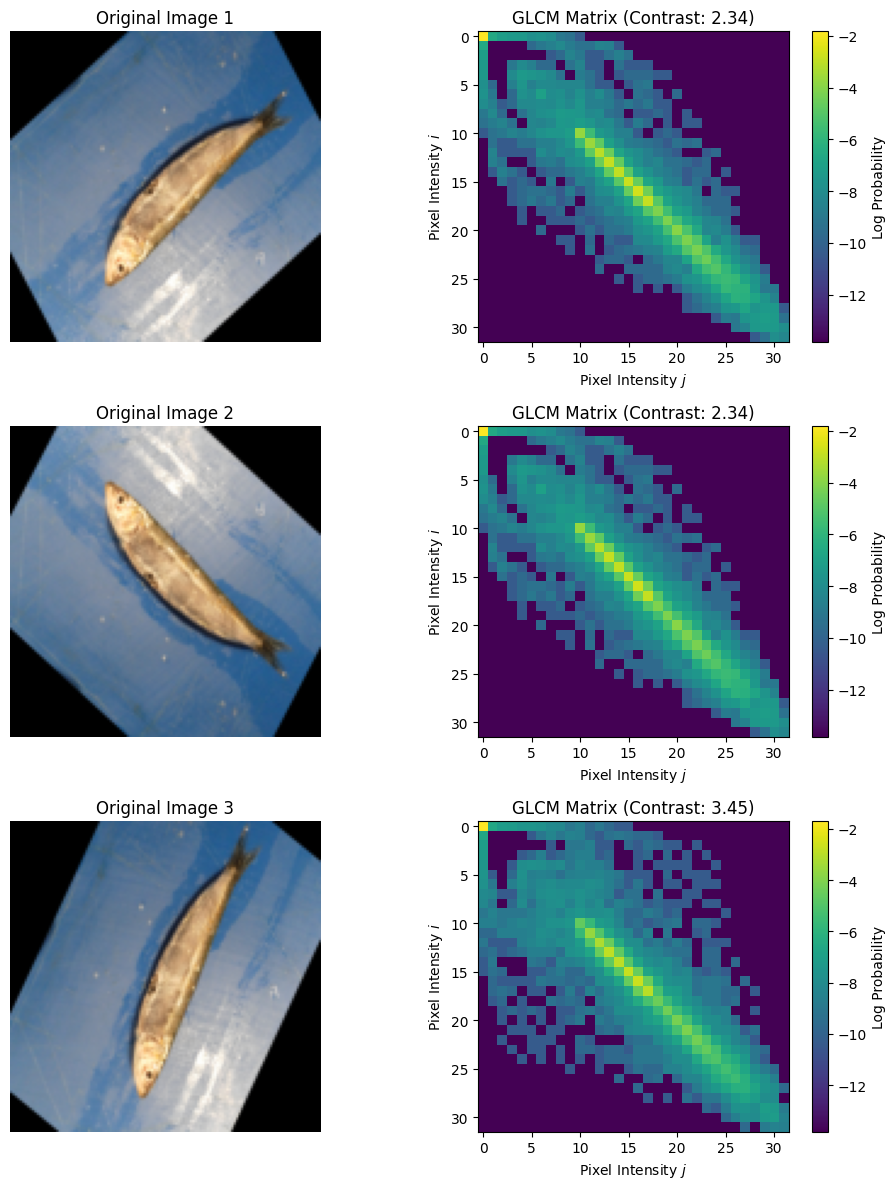

In [7]:
def visualize_glcm_samples(images, num=3):
    plt.figure(figsize=(10, num * 4))  # Increased height slightly for matrices

    # GLCM Parameters (matching your notebook)
    levels = 32
    distances = [1]
    angles = [0] # Visualizing just the 0-degree angle for clarity

    for i in range(num):
        img = images[i]

        # 1. Preprocessing: Convert to Grayscale if RGB
        if img.ndim == 3:
            gray = rgb2gray(img)
        else:
            gray = img

        # 2. Quantize image to 0..levels-1 (Critical step for GLCM)
        # This reduces 256 colors down to 32 to make the matrix dense enough to be useful
        image_q = np.clip(np.round(gray * (levels - 1)), 0, levels - 1).astype(np.uint8)

        # 3. Compute GLCM
        # Output shape is (levels, levels, len(distances), len(angles))
        glcm = graycomatrix(image_q, distances=distances, angles=angles, 
                            levels=levels, symmetric=True, normed=True)
        
        # Extract the 2D matrix for the specific distance/angle (0,0) to plot
        glcm_matrix = glcm[:, :, 0, 0]
        
        # (Optional) Calculate a feature to show in title
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        energy = graycoprops(glcm, 'energy')[0, 0]

        # --- Plotting ---
        
        # Original Image
        plt.subplot(num, 2, i*2 + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Original Image {i+1}")
        plt.axis('off')

        # GLCM Visualization (Heatmap)
        plt.subplot(num, 2, i*2 + 2)
        # Log scale helps visualize the matrix better if one diagonal dominates
        plt.imshow(np.log(glcm_matrix + 1e-6), cmap='viridis') 
        plt.title(f"GLCM Matrix (Contrast: {contrast:.2f})")
        plt.xlabel("Pixel Intensity $j$")
        plt.ylabel("Pixel Intensity $i$")
        plt.colorbar(label="Log Probability")

    plt.tight_layout()
    plt.show()

# Run the function
visualize_glcm_samples(X, num=3)

###  Compile and Train ANN model

In [8]:
# --- 5-Fold Cross-Validation Setup ---
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

num_classes = len(np.unique(y_full))
# Variables to hold data from the best performing fold
best_ann_score = -1
best_ann_history = None
best_ann_y_pred = None   # Predictions from the best fold
best_ann_y_true = None   # True labels from the best fold
best_ann_fold_index = -1

print("Starting 5-Fold CV for ANN...")

fold_no = 1
for train_index, val_index in kfold.split(X_full_glcm, y_full):
    # 1. Split Data
    X_t, X_v = X_full_glcm[train_index], X_full_glcm[val_index]
    y_t, y_v = y_full[train_index], y_full[val_index]
    
    # 2. One-Hot Encoding for ANN
    y_t_oh = to_categorical(y_t, num_classes)
    y_v_oh = to_categorical(y_v, num_classes)
    
    # 3. Scale Data (Fit on Train, Transform Validation)
    scaler_cv = StandardScaler()
    X_t = scaler_cv.fit_transform(X_t)
    X_v = scaler_cv.transform(X_v)
    
    # 4. Define Model (Fresh model for each fold)
    model_cv = Sequential([
        Input(shape=(X_t.shape[1],)),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model_cv.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # 5. Train
    print(f"Training Fold {fold_no}...", end=" ")
    history = model_cv.fit(X_t, y_t_oh, epochs=20, batch_size=64, validation_data=(X_v, y_v_oh), verbose=0)
    
    # 6. Evaluate
    loss, acc = model_cv.evaluate(X_v, y_v_oh, verbose=0)
    print(f"Accuracy: {acc*100:.2f}%")
    
    # 7. Save Best Fold Data
    if acc > best_ann_score:
        best_ann_score = acc
        best_ann_fold_index = fold_no
        best_ann_history = history
        
        # Generate predictions for later evaluation cells
        preds_oh = model_cv.predict(X_v, verbose=0)
        best_ann_y_pred = np.argmax(preds_oh, axis=1)
        best_ann_y_true = y_v
        
    fold_no += 1

print(f"\nTraining Complete. Best ANN Fold: {best_ann_fold_index} (Accuracy: {best_ann_score*100:.2f}%)")

Starting 5-Fold CV for ANN...
Training Fold 1... Accuracy: 81.39%
Training Fold 2... Accuracy: 81.83%
Training Fold 3... Accuracy: 83.06%
Training Fold 4... Accuracy: 82.39%
Training Fold 5... Accuracy: 83.94%

Training Complete. Best ANN Fold: 5 (Accuracy: 83.94%)


###  ANN Model Evaluation

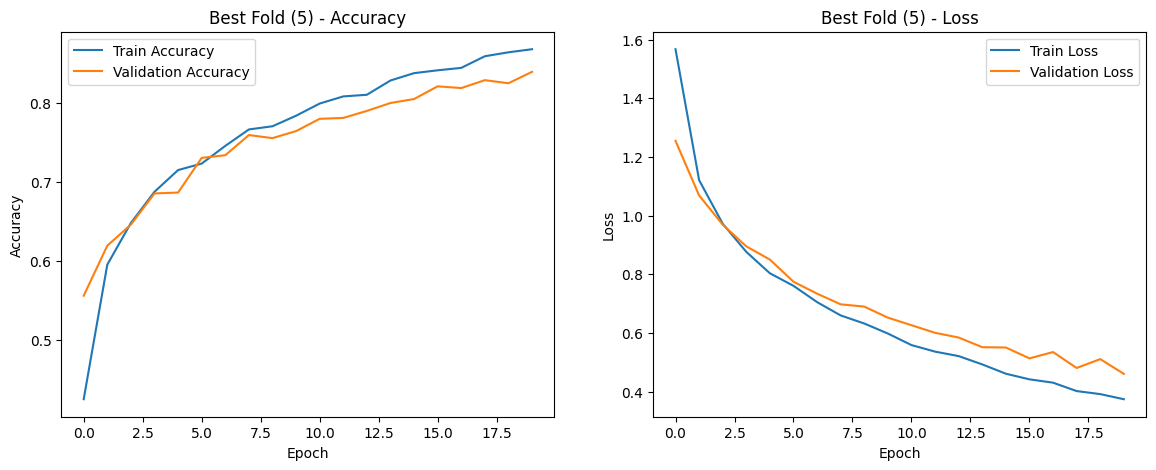

In [9]:
class_names = ['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']

plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(best_ann_history.history['accuracy'], label='Train Accuracy')
plt.plot(best_ann_history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'Best Fold ({best_ann_fold_index}) - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(best_ann_history.history['loss'], label='Train Loss')
plt.plot(best_ann_history.history['val_loss'], label='Validation Loss')
plt.title(f'Best Fold ({best_ann_fold_index}) - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


Confusion Matrix (Best Fold: 5):
 [[172   7   3   1   1  10   0   6   0]
 [  2 161   7   5   7   1   4   9   4]
 [  8   3 169   9   1   7   0   2   1]
 [  0   0   5 185   1   1   5   2   1]
 [  0  10   3  13 154   4   0  12   4]
 [  3  12   0  11   0 169   0   2   3]
 [  4   0   6   1   3   0 168  18   0]
 [ 12   8   8  11   2   3   6 148   2]
 [  0   5   0   1   3   5   0   1 185]]


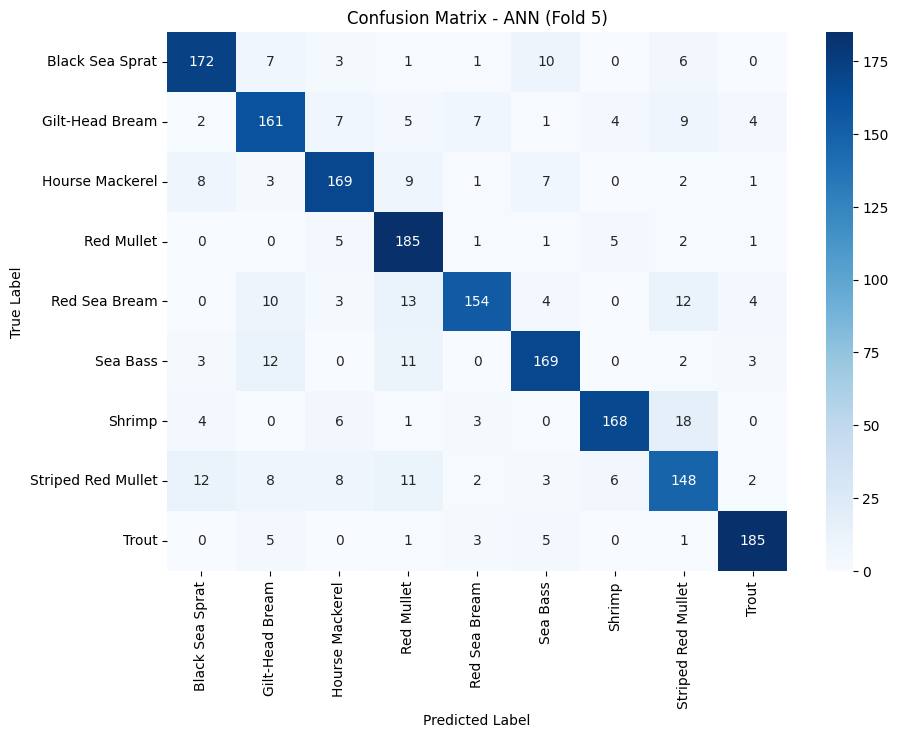

In [10]:
# Compute Matrix
conf_matrix_ann = confusion_matrix(best_ann_y_true, best_ann_y_pred)
print(f"Confusion Matrix (Best Fold: {best_ann_fold_index}):\n", conf_matrix_ann)

# Plot Heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_ann, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix - ANN (Fold {best_ann_fold_index})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [13]:
print(f"Classification Report (Best Fold: {best_ann_fold_index}):\n")
print(classification_report(best_ann_y_true, best_ann_y_pred, target_names=class_names, digits=4))

Classification Report (Best Fold: 5):

                    precision    recall  f1-score   support

   Black Sea Sprat     0.8557    0.8600    0.8579       200
   Gilt-Head Bream     0.7816    0.8050    0.7931       200
   Hourse Mackerel     0.8408    0.8450    0.8429       200
        Red Mullet     0.7806    0.9250    0.8467       200
     Red Sea Bream     0.8953    0.7700    0.8280       200
          Sea Bass     0.8450    0.8450    0.8450       200
            Shrimp     0.9180    0.8400    0.8773       200
Striped Red Mullet     0.7400    0.7400    0.7400       200
             Trout     0.9250    0.9250    0.9250       200

          accuracy                         0.8394      1800
         macro avg     0.8424    0.8394    0.8395      1800
      weighted avg     0.8424    0.8394    0.8395      1800



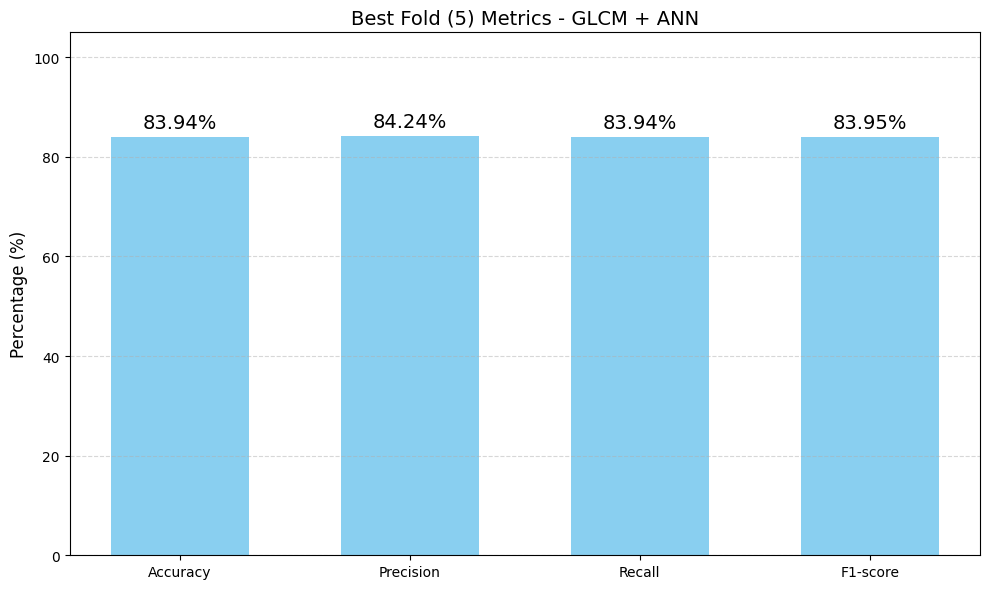

In [14]:
def plot_metrics_graph(metrics_values, title):
    # 1. Setup Data
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-score']
    
    # Check if input length matches expected metrics
    if len(metrics_values) != 4:
        print("Warning: Expected 4 metric values (Accuracy, Precision, Recall, F1).")

    # Convert values to percentages
    values_pct = [x * 100 for x in metrics_values]
    
    # 2. Create the Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create bars
    bars = ax.bar(metric_names, values_pct, color='#89CFF0', width=0.6, zorder=1)
    
    # 3. Add Value Labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.2f}%',
                ha='center', va='bottom', fontsize=14, color='black')
    
    # 4. Styling
    ax.set_title(title, fontsize=14)
    ax.set_ylabel('Percentage (%)', fontsize=12)
    ax.set_ylim(0, 105) 
    ax.grid(axis='y', linestyle='--', alpha=0.5, zorder=0)
    
    plt.tight_layout()
    plt.show()

GLCM_ANN = [0.8394,  0.8424  ,  0.8394  ,  0.8395]
plot_metrics_graph(GLCM_ANN, 'Best Fold (5) Metrics - GLCM + ANN')

### KNN model

In [15]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=3)

# Variables to hold best fold data
best_knn_score = -1
best_knn_y_pred = None
best_knn_y_true = None
best_knn_fold = -1

print("Starting 5-Fold CV for KNN...")

fold_no = 1
for train_index, val_index in kfold.split(X_full_glcm, y_full):
    # 1. Split Data
    X_t, X_v = X_full_glcm[train_index], X_full_glcm[val_index]
    y_t, y_v = y_full[train_index], y_full[val_index]
    
    # 2. Scale Data (Fit on Train, Transform Val)
    scaler = StandardScaler()
    X_t = scaler.fit_transform(X_t)
    X_v = scaler.transform(X_v)
    
    # 3. Train
    knn_model.fit(X_t, y_t)
    
    # 4. Predict
    preds = knn_model.predict(X_v)
    acc = accuracy_score(y_v, preds)
    
    print(f"Fold {fold_no} Accuracy: {acc*100:.2f}%")
    
    # 5. Save Best
    if acc > best_knn_score:
        best_knn_score = acc
        best_knn_fold = fold_no
        best_knn_y_pred = preds
        best_knn_y_true = y_v
        
    fold_no += 1

print(f"\nBest KNN Fold: {best_knn_fold} (Accuracy: {best_knn_score*100:.2f}%)")

Starting 5-Fold CV for KNN...
Fold 1 Accuracy: 80.50%
Fold 2 Accuracy: 81.00%
Fold 3 Accuracy: 82.39%
Fold 4 Accuracy: 83.06%
Fold 5 Accuracy: 82.83%

Best KNN Fold: 4 (Accuracy: 83.06%)


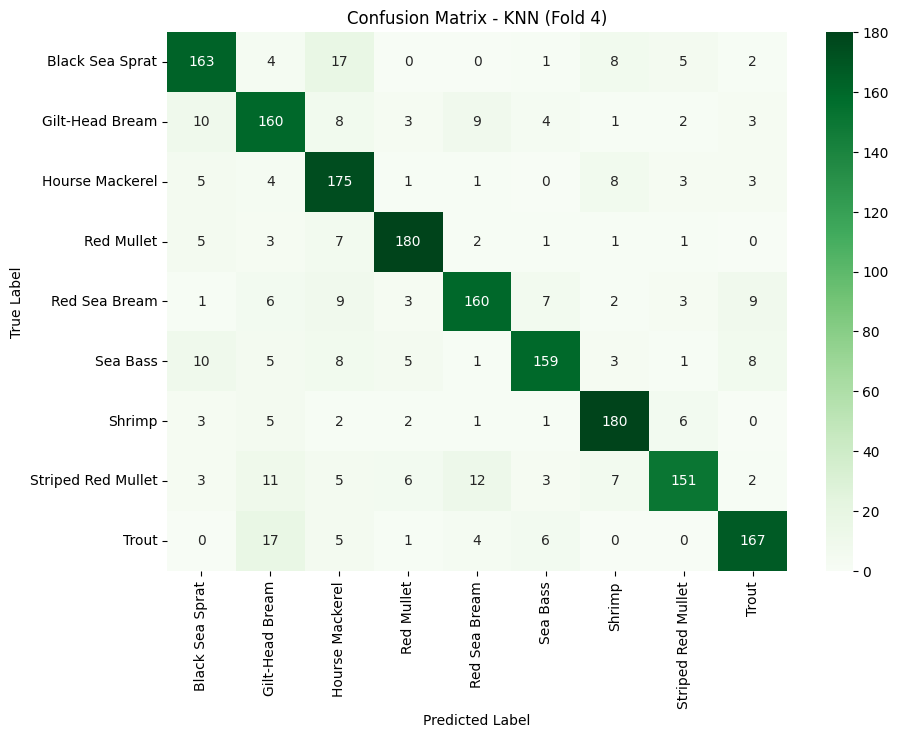

KNN Classification Report (Fold 4):

                    precision    recall  f1-score   support

   Black Sea Sprat     0.8150    0.8150    0.8150       200
   Gilt-Head Bream     0.7442    0.8000    0.7711       200
   Hourse Mackerel     0.7415    0.8750    0.8028       200
        Red Mullet     0.8955    0.9000    0.8978       200
     Red Sea Bream     0.8421    0.8000    0.8205       200
          Sea Bass     0.8736    0.7950    0.8325       200
            Shrimp     0.8571    0.9000    0.8780       200
Striped Red Mullet     0.8779    0.7550    0.8118       200
             Trout     0.8608    0.8350    0.8477       200

          accuracy                         0.8306      1800
         macro avg     0.8342    0.8306    0.8308      1800
      weighted avg     0.8342    0.8306    0.8308      1800



In [17]:
# 1. Confusion Matrix
plt.figure(figsize=(10, 7))
cm = confusion_matrix(best_knn_y_true, best_knn_y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix - KNN (Fold {best_knn_fold})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 2. Classification Report
print(f"KNN Classification Report (Fold {best_knn_fold}):\n")
print(classification_report(best_knn_y_true, best_knn_y_pred, target_names=class_names, digits=4))

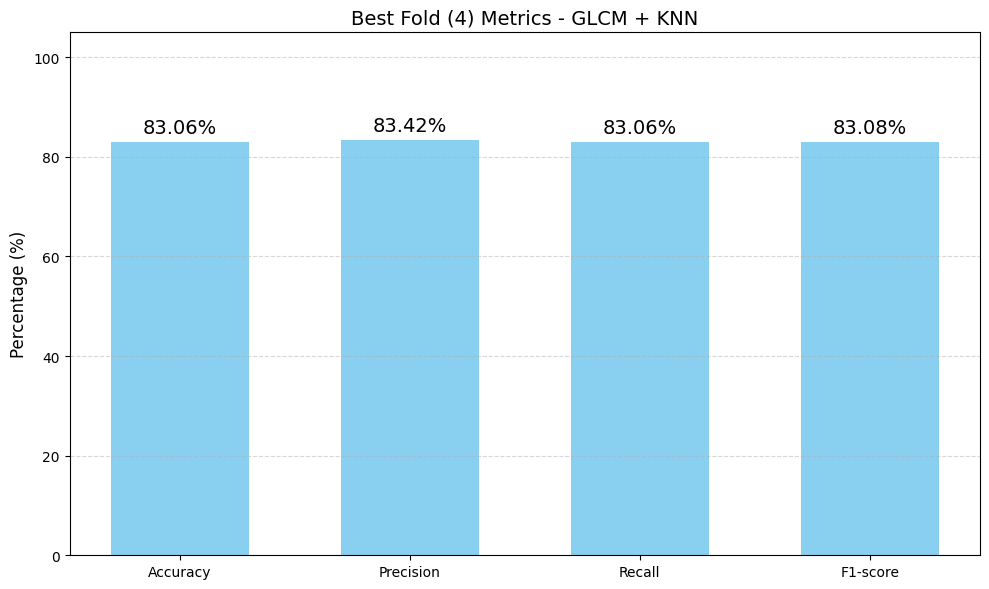

In [23]:
GLCM_KNN = [0.8306,  0.8342  ,  0.8306   , 0.8308]
plot_metrics_graph(GLCM_KNN, 'Best Fold (4) Metrics - GLCM + KNN') 

### SVM model

In [19]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Variables to hold best fold data
best_svm_score = -1
best_svm_y_pred = None
best_svm_y_true = None
best_svm_fold = -1

print("Starting 5-Fold CV for SVM...")

fold_no = 1
for train_index, val_index in kfold.split(X_full_glcm, y_full):
    # 1. Split Data
    X_t, X_v = X_full_glcm[train_index], X_full_glcm[val_index]
    y_t, y_v = y_full[train_index], y_full[val_index]
    
    # 2. Scale Data
    scaler = StandardScaler()
    X_t = scaler.fit_transform(X_t)
    X_v = scaler.transform(X_v)

    # 3. Train
    svm_model = SVC(kernel='rbf', probability=True)
    svm_model.fit(X_t, y_t)
    
    # 4. Predict
    preds = svm_model.predict(X_v)
    acc = accuracy_score(y_v, preds)
    
    print(f"Fold {fold_no} Accuracy: {acc*100:.2f}%")
    
    # 5. Save Best
    if acc > best_svm_score:
        best_svm_score = acc
        best_svm_fold = fold_no
        best_svm_y_pred = preds
        best_svm_y_true = y_v
        
    fold_no += 1

print(f"\nBest SVM Fold: {best_svm_fold} (Accuracy: {best_svm_score*100:.2f}%)")
 


Starting 5-Fold CV for SVM...
Fold 1 Accuracy: 69.28%
Fold 2 Accuracy: 70.28%
Fold 3 Accuracy: 69.61%
Fold 4 Accuracy: 69.56%
Fold 5 Accuracy: 69.56%

Best SVM Fold: 2 (Accuracy: 70.28%)


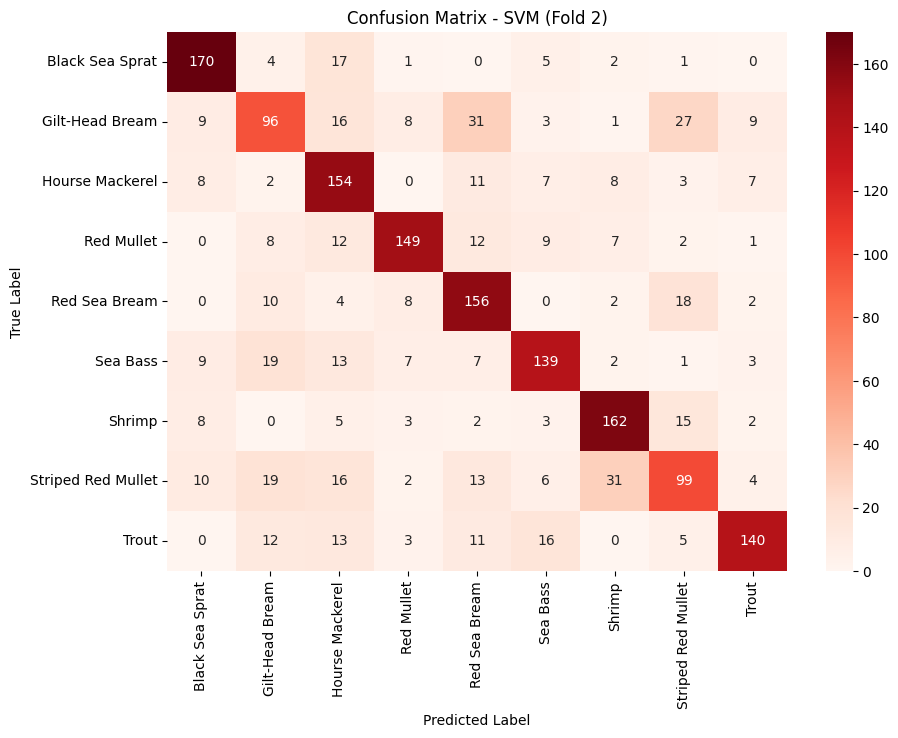

SVM Classification Report (Fold 2):

                    precision    recall  f1-score   support

   Black Sea Sprat     0.7944    0.8500    0.8213       200
   Gilt-Head Bream     0.5647    0.4800    0.5189       200
   Hourse Mackerel     0.6160    0.7700    0.6844       200
        Red Mullet     0.8232    0.7450    0.7822       200
     Red Sea Bream     0.6420    0.7800    0.7043       200
          Sea Bass     0.7394    0.6950    0.7165       200
            Shrimp     0.7535    0.8100    0.7807       200
Striped Red Mullet     0.5789    0.4950    0.5337       200
             Trout     0.8333    0.7000    0.7609       200

          accuracy                         0.7028      1800
         macro avg     0.7050    0.7028    0.7003      1800
      weighted avg     0.7050    0.7028    0.7003      1800



In [20]:
class_names = ['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']

# 1. Confusion Matrix
plt.figure(figsize=(10, 7))
cm = confusion_matrix(best_svm_y_true, best_svm_y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix - SVM (Fold {best_svm_fold})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 2. Classification Report
print(f"SVM Classification Report (Fold {best_svm_fold}):\n")
print(classification_report(best_svm_y_true, best_svm_y_pred, target_names=class_names, digits=4))  

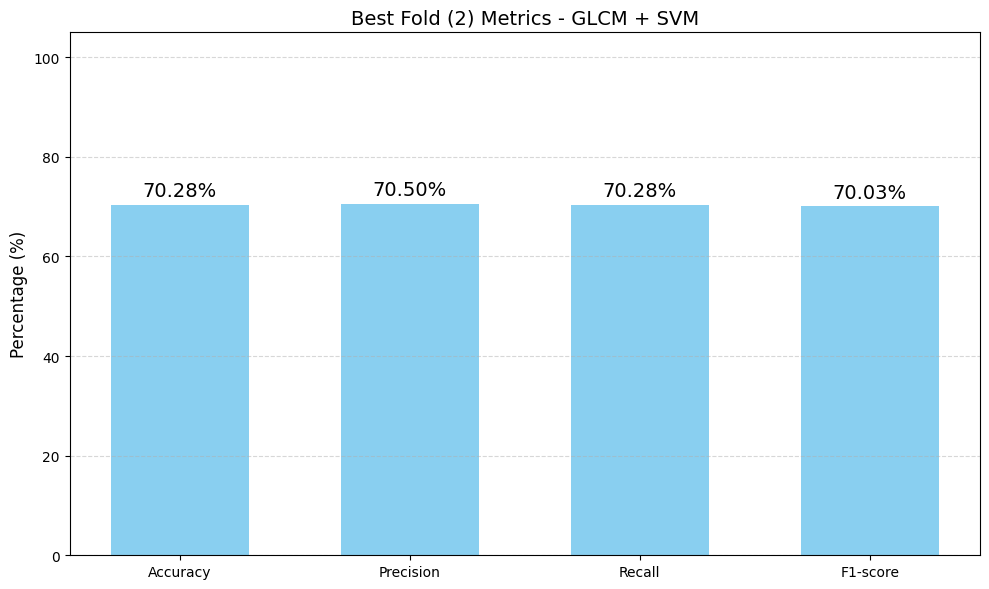

In [24]:
GLCM_SVM = [0.7028,  0.7050  ,  0.7028  ,  0.7003]
plot_metrics_graph(GLCM_SVM, 'Best Fold (2) Metrics - GLCM + SVM') 